# Import Libraries and define directories

In [1]:
from tqdm.autonotebook import tqdm
from src.data_preparation import run_gypsumdl
import pandas as pd
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from src.docking import *
from src.rescoring import rescoring_function
from src.preprocessing import merge_activity_values, hdbscan_scaffold_split, cv_split
from src.pose_score_optimization import scores_preprocessing, score_pose_optimization, prepare_parameters, prediction, mapping_normalized_weights

import matplotlib.pyplot as plt
import seaborn as sns  
from pathlib import Path

/tmp/ipykernel_407563/1138675477.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
protein_name  = '5UG9_noligand_protoss.pdb'
ligand_library = 'test_three_cpds.sdf'
reference_ligand = 'ref_ligand.pdb'

In [3]:
HERE = Path(_dh[-1])
DATA = (HERE / "test_data")
software = (HERE / "software")
protein_file = (DATA  / protein_name)
ligand_library = (DATA / ligand_library)
ref_file = (DATA /  reference_ligand)


OUTPUT = DATA / "results"
OUTPUT.mkdir(exist_ok=True)

In [19]:
test_df = PandasTools.LoadSDF(str(ligand_library))
# apply pd.to_numeric to the entire dataframe
test_df = test_df.apply(pd.to_numeric, errors='ignore')
test_df.drop(columns=['activity_class'], inplace=True)
# make threshold of 8 pIC50
threshold_value = 8.00

# Create a new column 'activity_class' based on the threshold
test_df['activity_class'] = (test_df['true_value'] >= threshold_value).astype(int)
# PandasTools.WriteSDF(
#     test_df, 
#     str(DATA / 'test_library.sdf'), 
#     idName='ID',
#     molColName='ROMol',
#     properties=list(test_df.columns),
#     )

8.0

## Prepare CSV file

Drop rows with NaN values to have: 7280
Drop duplicate smiles to have: 7039
Keep molecules with IC50 only to have: 6687


,standard_type,ID,true_value,standard_units,canonical_smiles
0,pIC50,CHEMBL63786,11.522879,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1
1,pIC50,CHEMBL35820,11.221849,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC
2,pIC50,CHEMBL53711,11.221849,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1
3,pIC50,CHEMBL66031,11.096910,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1
4,pIC50,CHEMBL53753,11.096910,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1


<Axes: >

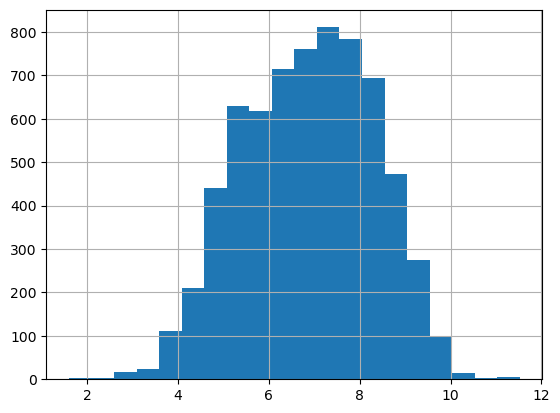

In [20]:
egfr_ligands_data = pd.read_csv(str(DATA / 'EGFR-activities-chembl33-sample.csv'))[
        [
            'activities.standard_type', 
            'molecule_dictionary.chembl_id', 
            'activities.standard_value', 
            'activities.standard_units', 
            'compound_structures.canonical_smiles',
        ]
    ]
egfr_ligands_data = egfr_ligands_data.rename(columns={
    'molecule_dictionary.chembl_id': 'ID',
    'activities.standard_value': 'true_value',
    'activities.standard_units': 'standard_units',
    'compound_structures.canonical_smiles': 'canonical_smiles',
    'activities.standard_type': 'standard_type',
})

egfr_ligands_data = egfr_ligands_data.dropna()
print(f"Drop rows with NaN values to have: {egfr_ligands_data.shape[0]}")
egfr_ligands_data = egfr_ligands_data.drop_duplicates(subset=['canonical_smiles'])
print(f"Drop duplicate smiles to have: {egfr_ligands_data.shape[0]}")

# take only activities with IC50 values
egfr_ligands_data_ic50 = egfr_ligands_data[egfr_ligands_data['standard_type'] == 'pIC50']
print(f"Keep molecules with IC50 only to have: {egfr_ligands_data_ic50.shape[0]}")
egfr_ligands_data_ic50.sort_values(by=['true_value'])
display(egfr_ligands_data_ic50.head())
# stratify molecules by their IC50 values
egfr_ligands_data_ic50['true_value'].hist(bins=20)

### Threshold of 8.00 pIC50 is considered to be active which are the 33.9% of the given data 

In [21]:
# make a column called activity class and assign 1 to active and 0 to inactive with a threshold of 6 for true_vale
egfr_ligands_data_ic50['activity_class'] = egfr_ligands_data_ic50['true_value'].apply(lambda x: 1 if x >= 8 else 0)
display(egfr_ligands_data_ic50.activity_class.value_counts())
egfr_ligands_data_ic50['ROMol'] = egfr_ligands_data_ic50['canonical_smiles'].apply(lambda x: Chem.MolFromSmiles(x))

print(egfr_ligands_data_ic50['activity_class'].value_counts())
# make a random split of the data stratified by the true_value
train, test = train_test_split(egfr_ligands_data_ic50, test_size=0.03, random_state=42, stratify=egfr_ligands_data_ic50['activity_class'])
test['activity_class'].value_counts()

# PandasTools.WriteSDF(
#     test, 
#     str(OUTPUT / 'test_library.sdf'), 
#     idName='chembl_id',
#     molColName='ROMol',
#     properties=list(test.columns),
#     )
# PandasTools.WriteSDF(
#     train, 
#     str(OUTPUT / 'train_library.sdf'),
#     idName='chembl_id', 
#     molColName='ROMol', 
#     properties=list(train.columns)
#     )

/tmp/ipykernel_2220518/2593485849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egfr_ligands_data_ic50['activity_class'] = egfr_ligands_data_ic50['true_value'].apply(lambda x: 1 if x >= 8 else 0)


activity_class
0    4989
1    1698
Name: count, dtype: int64

activity_class
0    4989
1    1698
Name: count, dtype: int64


/tmp/ipykernel_2220518/2593485849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egfr_ligands_data_ic50['ROMol'] = egfr_ligands_data_ic50['canonical_smiles'].apply(lambda x: Chem.MolFromSmiles(x))


activity_class
0    150
1     51
Name: count, dtype: int64

# MolDockLab Workflow

## Prepare ligands library

In [9]:
ligand_library = DATA / 'test_three_cpds.sdf'
output_prepared_mols = DATA / f"{ligand_library.stem}_prepared.sdf"
run_gypsumdl(
    ligand_library=ligand_library, 
    prepared_library_path=output_prepared_mols, 
    id_column="chembl_id"
    )

Molecules are already prepared by Gypsum-DL


In [8]:
# Package for MolDockLab is DockM8 + next libraries

hdscan
pip install "fair-esm[esmfold]"
e3nn


!cd software/
!git clone git@github.com:mbackenkoehler/DiffDock.git
! git clone git@github.com:sc8668/RTMScore.git
!cd ../

pydantic
pip install dgl==1.1.3

Cloning into 'DiffDock'...
remote: Enumerating objects: 484, done.
remote: Counting objects: 100% (336/336), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 484 (delta 192), reused 235 (delta 138), pack-reused 148
Receiving objects: 100% (484/484), 233.07 MiB | 19.92 MiB/s, done.
Resolving deltas: 100% (221/221), done.


## Consensus Docking

In [10]:
docking_programs = [
                'GNINA', 
                'SMINA',
                'diffdock', 
                'PLANTS', 
                'flexx',
                ]

n_poses = 10
exhaustiveness = 8

In [18]:
from src.docking import docking

docking(
        docking_programs,
        protein_file,
        output_prepared_mols,
        ref_file,
        exhaustiveness,
        n_poses,
        OUTPUT,
        local_diffdock=True
        )



Docking with GNINA is running ...

Compounds are already docked with GNINA v 1.0


Docking with SMINA is running ...

Compounds are already docked with SMINA


Docking with DIFFDOCK is running ...

Binding pocket is already extracted


Local DiffDock is running ...: 100%|██████████| 3/3 [00:00<00:00, 8744.21it/s]

Compound CHEMBL460721 is already docked with DiffDock
Compound CHEMBL4858409 is already docked with DiffDock
Compound CHEMBL3133894 is already docked with DiffDock
ERROR: [Errno 20] Not a directory: '/home/hamza/github/MolDockLab/ECFT-VS-pipeline/test_data/results/diffdock/diffdock_poses.sdf'

Compounds are already docked and concatenated, CHECK /home/hamza/github/MolDockLab/ECFT-VS-pipeline/test_data/results/diffdock/diffdock_poses.sdf


Docking with PLANTS is running ...

/home/hamza/github/MolDockLab/ECFT-VS-pipeline/test_data/test_three_cpds_prepared.sdf
PLANTS preprocessing is running ...
	 Converting to Mol2
5UG9_noligand_protoss is already converted to mol2 format
test_three_cpds_prepared is already converted to mol2 format
ref_ligand is already converted to mol2 format


                  PLANTS
        Protein-Ligand ANT System
               version 1.2


author: Oliver Korb

scientific contributors: T.E. Exner, T. Stuetzle

contact: Oliver.Korb@uni-konstanz.de


run PLANTS: 

### PoseBusters for quality checking

In [20]:
protein_name = 'egfr'
docking_tools_results = poses_checker(
    poses_path= OUTPUT / 'allposes.sdf', 
    protein_path= protein_file, 
    output_file= OUTPUT / f'{protein_name}_posebusters_results.csv'
    )
docking_tools_results

PoseBusters is running ...


,docking_tool,internal_steric_clash,internal_energy,minimum_distance_to_protein,volume_overlap_with_protein,Number of Docked Molecules
0,flexx,0,2,20,0,3
1,gnina,0,1,0,0,3
2,localdiffdock,3,2,29,10,3
3,plants,0,3,3,0,3
4,smina,0,1,0,0,3


## Scoring Functions

In [21]:
rescoring = [
    'cnnscore', 
    'cnnaffinity',  
    'smina_affinity',
    'ad4',  
    'linf9', 
    'rtmscore', 
    'vinardo', 
    # 'scorch',
    'hyde', 
    'chemplp', 
    'rfscorevs_v1',
    'rfscorevs_v2',
    'rfscorevs_v3', 
    'vina_hydrophobic', 
    'vina_intra_hydrophobic'
    ]
# Load important dataframes

In [22]:
docked_library_path = OUTPUT / f"allposes.sdf"

rescoring_function(
    rescoring,
    protein_file,
    docked_library_path,
    ref_file,
    ncpu=1,
)

protein is already converted to mol2
protein is already converted to mol2


Now rescoring with CNNSCORE ... ⌛⌛ 
cnnscore is already excuted
cnnscore is already read


Now rescoring with CNNAFFINITY ... ⌛⌛ 
cnnaffinity is already excuted
cnnaffinity is already read


Now rescoring with SMINA_AFFINITY ... ⌛⌛ 
smina_affinity is already excuted
smina_affinity is already read


Now rescoring with AD4 ... ⌛⌛ 
ad4 is already excuted
ad4 is already read


Now rescoring with LINF9 ... ⌛⌛ 
linf9 is already excuted
linf9 is already read


Now rescoring with RTMSCORE ... ⌛⌛ 
rtmscore is already excuted
rtmscore is already read


Now rescoring with VINARDO ... ⌛⌛ 
vinardo is already excuted
vinardo is already read


Now rescoring with HYDE ... ⌛⌛ 
hyde is already excuted
hyde is already read
sdf_0.sdf is converted to mol2


Now rescoring with CHEMPLP ... ⌛⌛ 
chemplp is already excuted
chemplp is already read


Now rescoring with RFSCOREVS_V1 ... ⌛⌛ 
rfscorevs_v1 is already excuted
rfscorevs_v1 is a

150 molecules converted


### Scores Normalization

#### Merging true value and splitting

In [5]:
df_rescored_merged = merge_activity_values(
    norm_scored_path = OUTPUT / 'all_rescoring_results.csv', 
    true_value_path = ligand_library,
    true_value_col = 'true_value',
    scored_id_col='ID',
    activity_col='activity_class',
    lower_better_true_value = False,
    threshold=0.9
    )

,CNNscore,CNNaffinity,smina_affinity,ad4,LinF9,RTMScore,Vinardo,HYDE,CHEMPLP,rfscore_v1,rfscore_v2,rfscore_v3,vina_hydrophobic,vina_intra_hydrophobic,true_value,activity_class
CNNscore,1.000000,0.355153,-0.458041,-0.462576,-0.353260,-0.051434,-0.465465,-0.107454,-0.063516,-0.355944,-0.350176,-0.308254,-0.006252,-0.091598,-0.238602,-0.018265
CNNaffinity,0.355153,1.000000,-0.586337,-0.600805,-0.625464,0.384559,-0.622411,-0.010653,-0.140179,0.456549,0.433832,0.547322,-0.345899,0.554118,0.528808,0.360912
smina_affinity,-0.458041,-0.586337,1.000000,0.968098,0.964207,-0.063376,0.996627,0.359339,0.177697,0.083484,0.092301,0.000454,0.311578,0.045290,0.011283,0.018925
ad4,-0.462576,-0.600805,0.968098,1.000000,0.943350,-0.088742,0.967580,0.319373,0.228931,0.118568,0.122199,0.023800,0.277229,0.043943,-0.000596,-0.018827
LinF9,-0.353260,-0.625464,0.964207,0.943350,1.000000,-0.136343,0.959669,0.340860,0.222350,-0.022069,-0.018639,-0.122079,0.380435,0.029516,0.001673,0.117456
RTMScore,-0.051434,0.384559,-0.063376,-0.088742,-0.136343,1.000000,-0.094359,0.014337,-0.099392,0.464113,0.447473,0.448737,-0.459162,0.352680,0.389554,0.079522
Vinardo,-0.465465,-0.622411,0.996627,0.967580,0.959669,-0.094359,1.000000,0.340855,0.174686,0.056359,0.061766,-0.026831,0.324783,0.008079,-0.029321,-0.020744
HYDE,-0.107454,-0.010653,0.359339,0.319373,0.340860,0.014337,0.340855,1.000000,-0.025537,0.132166,0.088322,0.093391,-0.026630,0.057007,0.019222,-0.065253
CHEMPLP,-0.063516,-0.140179,0.177697,0.228931,0.222350,-0.099392,0.174686,-0.025537,1.000000,0.317672,0.343321,0.257620,0.020990,-0.096909,0.377998,0.273948
rfscore_v1,-0.355944,0.456549,0.083484,0.118568,-0.022069,0.464113,0.056359,0.132166,0.317672,1.000000,0.932419,0.936627,-0.410944,0.486258,0.770161,0.262330


Scores of {'ad4', 'Vinardo', 'rfscore_v1', 'rfscore_v2', 'LinF9'} were found to highly correlate. Therefore, they are removed


## Scaffold split for versatility checking 

In [5]:
clustered_df = hdbscan_scaffold_split(ligand_library, min_cluster_size=2)
cv_split(clustered_df, df_rescored_merged, idx_col='ID', n_splits=5, output_path= DATA / 'data_splits', target_name='egfr')

Number of unique scaffolds: 3
Number of HDBSCAN clusters: 1


[13:22:23] DEPRECATION WARNING: please use MorganGenerator
[13:22:23] DEPRECATION WARNING: please use MorganGenerator
[13:22:23] DEPRECATION WARNING: please use MorganGenerator


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=3.

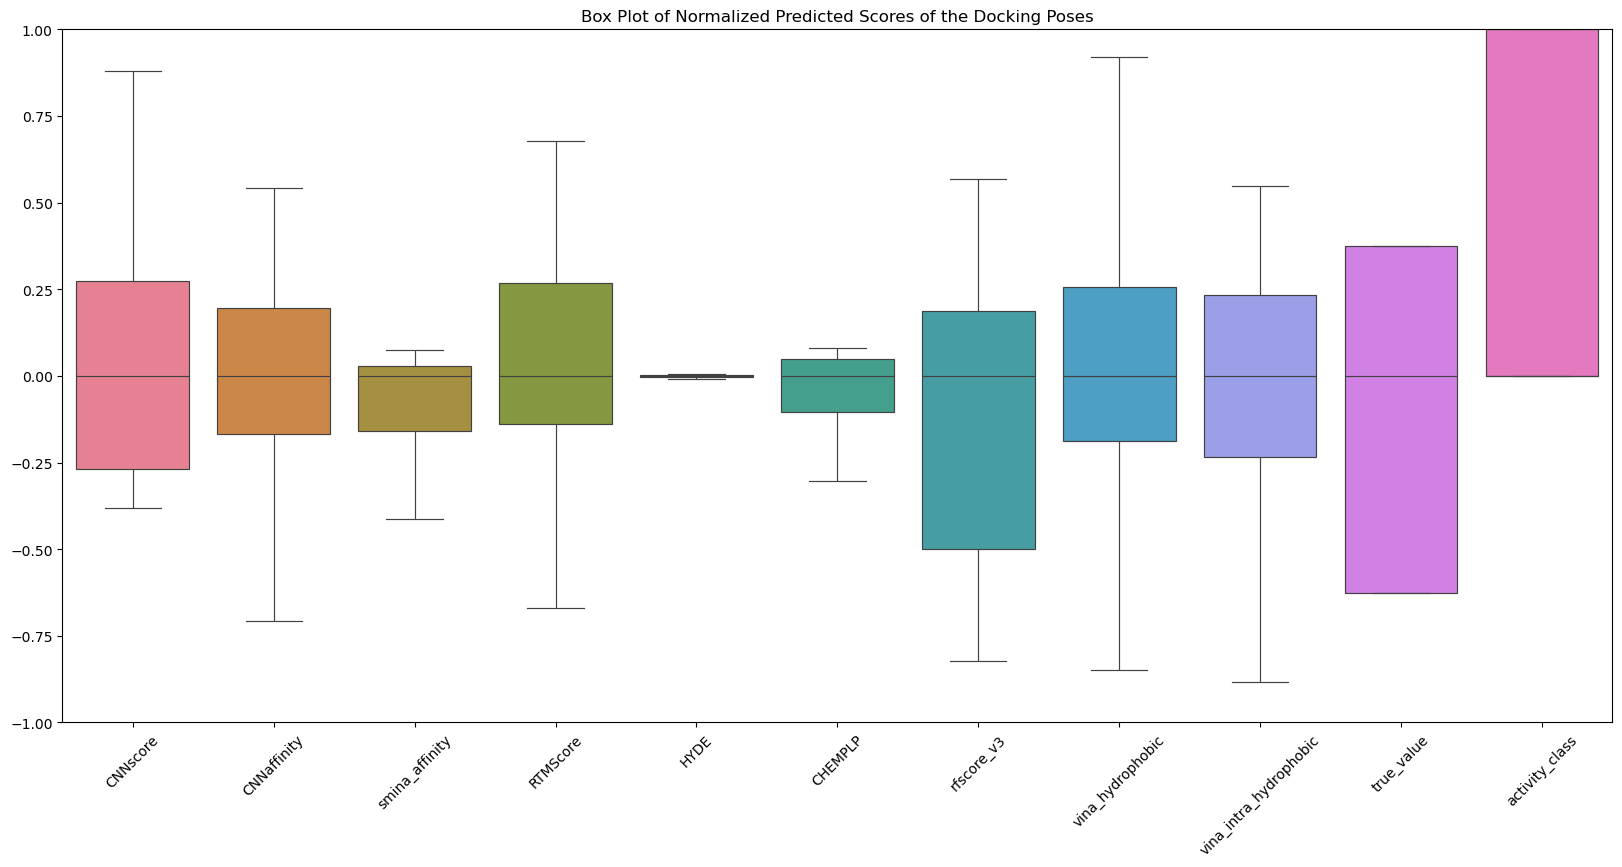

In [6]:
from src.preprocessing import norm_scores

norm_scored_path = OUTPUT / 'all_rescoring_results_merged_norm_robust.csv'
df_rescored = pd.read_csv(str(OUTPUT / 'all_rescoring_results.csv'))

df_rescored_norm = norm_scores(df_rescored_merged)

plt.figure(figsize=(20, 9))
sns.boxplot(data=df_rescored_norm ,linewidth=.85, showfliers=False)
plt.ylim(-1, 1)
plt.title('Box Plot of Normalized Predicted Scores of the Docking Poses')
plt.xticks(rotation=45) 
plt.show()

df_rescored_norm.to_csv(str(norm_scored_path), index=False)


## Pose Score Optimization

### Executing optimization function for different regularization

In [18]:
regs = [0, 0.3, 0.5, 0.7, 1, 3, 5, 10, 50]
X, y, docking_cost, scoring_cost, docking_tools, scoring_tools = scores_preprocessing(df_rescored_merged)
best_weights = score_pose_optimization(X, y, docking_cost, scoring_cost, weights_path= DATA / 'best_weights_all_reg_nocoll_abs.pkl.npy', alphas=regs, iter=500)
best_weights

100%|██████████| 150/150 [00:00<00:00, 10574.41it/s]


{0: array([ 0.06052566,  0.09143236, -0.21542251,  1.57871441,  0.01284786,
        -0.25091847,  0.03708087,  0.33071441,  0.0028617 , -0.22055987,
         0.3298587 ,  0.03308206, -0.24248488,  0.20802495, -0.00837271]),
 0.3: array([ 8.18024520e-01,  4.42286192e-01,  2.83908644e-01,  4.57133676e-01,
         1.03337705e-01,  1.28012926e-01,  5.63623207e-02,  1.03747907e+00,
         6.74366301e-01,  5.51888579e-01, -1.40733620e-07, -1.70062642e-07,
         3.31679814e-07,  3.30561500e-08,  2.18646070e-07]),
 0.5: array([ 8.53593257e-01,  5.90680583e-01,  8.36588438e-01,  3.60468793e-01,
         9.09087555e-02,  4.71847544e-02,  6.04591626e-01,  2.81339004e-01,
         6.10037369e-01,  8.83671229e-01,  1.43567670e-07, -8.09443031e-08,
        -2.04506221e-07,  8.00482357e-09, -2.25486530e-08]),
 0.7: array([ 4.14652324e-01,  9.06638869e-02, -1.35679090e-01,  7.44045203e-02,
         5.91396152e-02,  5.45365841e-01,  3.13196818e+00,  4.00383292e-02,
         2.64147549e-02,  2.017

### Check the correlation of each alpha with the true value

In [8]:
for alpha in best_weights.keys():
    c_r, c_d = prepare_parameters(best_weights[alpha])
    preds = pd.DataFrame({'prediction': prediction(c_r, c_d, X), 'ground truth': y})
    corr = preds.corr('spearman')['ground truth']['prediction']
    # sns.lmplot(data=preds, x='prediction', y='ground truth')
    print(f"Using alpha {alpha} give a correlation of : {corr}")

RuntimeError: The size of tensor a (9) must match the size of tensor b (10) at non-singleton dimension 2

### Mapping the normalized weights to docking tools and scoring functions

In [9]:
selected_docking = {}
selected_rescoring = {}
for alpha in best_weights.keys():
    normalized_weights = mapping_normalized_weights(best_weights[alpha], scoring_tools, docking_tools)
    print(f"Using alpha {alpha} give normalized weights: \n{normalized_weights}\n")
    #extract the tools that is above 0.5 in a list
    selected_docking[alpha] = [key for key, value in list(normalized_weights.items())[:5] if value > 0.5]
    selected_rescoring[alpha] = [key for key, value in list(normalized_weights.items())[6:] if value > 0.5]
    print(f"Using alpha {alpha} give selected tools: \n For Docking:{selected_docking[alpha]}\n For Rescoring:{selected_rescoring[alpha]}\n")

Using alpha 0 give normalized weights: 
{'flexx': 0.038307424941427706, 'gnina': 1.0, 'localdiffdock': 0.4814711755597849, 'plants': 0.0, 'smina': 0.7871317979060262, 'CNNscore': 0.17022219862992502, 'CNNaffinity': 0.18711449582681922, 'smina_affinity': 0.019400590273120803, 'RTMScore': 1.0, 'HYDE': 0.14416352490129639, 'CHEMPLP': 0.0, 'rfscore_v3': 0.1574082658069239, 'vina_hydrophobic': 0.31789594758864076, 'vina_intra_hydrophobic': 0.13870551487660682}

Using alpha 0 give selected tools: 
 For Docking:['gnina', 'smina']
 For Rescoring:['RTMScore']

Using alpha 0.3 give normalized weights: 
{'flexx': 1.0, 'gnina': 5.314299797983338e-08, 'localdiffdock': 0.0, 'plants': 9.091369542974891e-07, 'smina': 3.680430026498131e-07, 'CNNscore': 0.7763216743386354, 'CNNaffinity': 0.39335162783000477, 'smina_affinity': 0.23192583682172088, 'RTMScore': 0.40848487663885635, 'HYDE': 0.04787950533351667, 'CHEMPLP': 0.07302964187648502, 'rfscore_v3': 0.0, 'vina_hydrophobic': 1.0, 'vina_intra_hydrophob

## Consensus Ranking

In [10]:
ranking_methods = [
                'best_ECR' ,
                'ECR_average',
                'average_ECR' ,
                'rank_by_rank' ,
                'rank_by_vote' ,
                'rank_by_number',
                'best_Zscore',
                'average_Zscore',
                'weighted_ECR'
                ]

In [12]:
from src.ranking import *
poses_ranking(
    ranking_methods,
    df_rescored_norm,
    OUTPUT,
    weights=normalized_weights,
)

Number of docking programs: 5, ['flexx', 'gnina', 'localdiffdock', 'plants', 'smina']
Number of rescoring methods: 9, ['CNNscore', 'CNNaffinity', 'smina_affinity', 'RTMScore', 'HYDE', 'CHEMPLP', 'rfscore_v3', 'vina_hydrophobic', 'vina_intra_hydrophobic']
Number of possible combinations for every ranking method: 15841
 With total combinations : 142569
File best_ECR exists. Skipping...
File ECR_average exists. Skipping...
File average_ECR exists. Skipping...
File rank_by_rank exists. Skipping...
File rank_by_vote exists. Skipping...
File rank_by_number exists. Skipping...
File best_Zscore exists. Skipping...
File average_Zscore exists. Skipping...
Parallelizing weighted_ECR...
Running weighted_ECR...Running weighted_ECR...Running weighted_ECR...Running weighted_ECR...Running weighted_ECR...Running weighted_ECR...

Running weighted_ECR...

Running weighted_ECR...Running weighted_ECR...
Running weighted_ECR...

Running weighted_ECR...



Running weighted_ECR...Running weighted_ECR...
Runni

/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ranking_method_name], df_rank_copy['true_value'])
/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ranking_method_name], df_rank_copy['true_value'])
/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ranking_method_name], df_rank_copy['true_value'])
/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ra

Running weighted_ECR...

/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ranking_method_name], df_rank_copy['true_value'])
/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ranking_method_name], df_rank_copy['true_value'])
/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ranking_method_name], df_rank_copy['true_value'])


Running weighted_ECR...

/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ranking_method_name], df_rank_copy['true_value'])


/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ranking_method_name], df_rank_copy['true_value'])


/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ranking_method_name], df_rank_copy['true_value'])
/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ranking_method_name], df_rank_copy['true_value'])
/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ranking_method_name], df_rank_copy['true_value'])
/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/ranking.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df_rank_copy.loc[:, ra

Finished weighted_ECR...


### Mapping the Pose Score Optimization to consensus ranking

In [14]:
corr_df = pd.read_csv(OUTPUT / f'correlations_general/all_ranked.csv')
corr_df

,docking_tool,scoring_function,spearman_correlation,cost_per_pipeline,enrichment_factor,ranking_method
0,"['flexx', 'smina']","['CNNscore', 'HYDE', 'RTMScore', 'rfscore_v3']",1.0,137.33,0,method6_Zscore_best
1,"['flexx', 'smina']","['CHEMPLP', 'CNNaffinity', 'CNNscore', 'rfscor...",1.0,120.64,0,method6_Zscore_best
2,"['flexx', 'smina']","['CHEMPLP', 'CNNaffinity', 'CNNscore', 'RTMSco...",1.0,121.64,0,method6_Zscore_best
3,"['flexx', 'smina']","['CHEMPLP', 'CNNaffinity', 'CNNscore', 'RTMSco...",1.0,121.64,0,method6_Zscore_best
4,"['flexx', 'smina']","['CHEMPLP', 'CNNaffinity', 'CNNscore', 'RTMSco...",1.0,121.64,0,method6_Zscore_best
...,...,...,...,...,...,...
142564,"['gnina', 'localdiffdock', 'plants', 'smina']","['CNNaffinity', 'CNNscore', 'HYDE', 'rfscore_v...",NaN,670.02,0,method9_weighted_ECR_best
142565,"['gnina', 'localdiffdock', 'plants', 'smina']","['CNNaffinity', 'CNNscore', 'RTMScore', 'rfsco...",NaN,654.12,0,method9_weighted_ECR_best
142566,"['gnina', 'localdiffdock', 'plants', 'smina']","['CNNaffinity', 'HYDE', 'RTMScore', 'rfscore_v...",NaN,671.02,0,method9_weighted_ECR_best
142567,"['gnina', 'localdiffdock', 'plants', 'smina']","['CNNscore', 'HYDE', 'RTMScore', 'rfscore_v3',...",NaN,671.02,0,method9_weighted_ECR_best


# Implementation of Larger Data

In [9]:
chembl_data = PandasTools.LoadSDF(str(DATA / 'train_library.sdf'))
chembl_data.head()

## Ligands preparation

In [5]:
OUTPUT = DATA / "chembl_results"
OUTPUT.mkdir(exist_ok=True)

chembl_library = str(OUTPUT / 'train_library.sdf')
prepared_chembl_data_path = OUTPUT / f"chembl_data_prepared.sdf"
run_gypsumdl(str(chembl_library), prepared_chembl_data_path)

Molecules are already prepared


## Molecular Docking of selected tools

In [50]:
from docking import docking

selected_docking_programs = [
    'smina',
    # 'gnina',
    # 'plants',
    'flexx',
    # 'diffdock',
    ]
docking(
        selected_docking_programs,
        protein_file,
        prepared_chembl_data_path,
        ref_file,
        32,
        10,
        OUTPUT
        )



Docking with FLEXX is running ...

Reference ligand is already in SDF format


: 

: 

## Interaction hotspots detection using PLIPify

In [4]:
from src.interaction_analysis import (
    split_sdf_path, 
    actives_extraction, 
    plipify_ligand_protein_interaction, 
    indiviudal_interaction_fp_generator, 
    read_interactions_json, 
    interactions_aggregation
)

from src.ranking import enrichment_factor_calc
from src.preprocessing import norm_scores
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

actives_path = actives_extraction( 
    DATA / 'results/allposes.sdf', 
    DATA / 'results/all_rescoring_results_merged.csv', 
    docking_tool='diffdock'
    )

ligands_paths = split_sdf_path(actives_path)

/home/hamza/miniconda3/envs/dockm8/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/home/hamza/miniconda3/envs/dockm8/lib/python3.10/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/home/hamza/miniconda3/envs/dockm8/lib/python3.10/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please import `netcdf_file` from the `scipy.io` namespace; the `scipy.io.netcdf` namespace is deprecated and will be removed in SciPy 2.0.0.
  class 

Number of active compounds: 510


SDF splitting: 100%|██████████| 510/510 [00:00<00:00, 3759.51it/s]


Fingerprint Interactions are already saved in /home/hamza/github/MolDockLab/ECFT-VS-pipeline/test_data/results/egfr_interactions_X.png


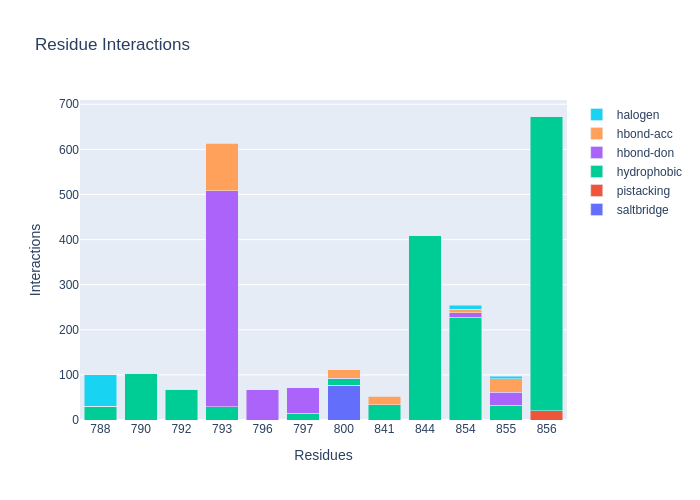

In [6]:
output_file=OUTPUT / 'egfr_interactions_X.png'
fp_focused = plipify_ligand_protein_interaction(
    ligands_path = ligands_paths, 
    protein_path=protein_file, 
    protein_name='EGFR', 
    chains='X',
    output_file=output_file
    )
display(Image(filename=output_file))

## Interaction fingerprints generations

In [9]:
included_chains = ['X']
protein_name = 'egfr'

allposes_interaction_fp = indiviudal_interaction_fp_generator(ligands_paths, 
                                                              protein_file, 
                                                              protein_name, 
                                                              included_chains, 
                                                              OUTPUT / 'fp_allposes.json')

Interactions for all poses are already executed


In [12]:
interactions_df = read_interactions_json(
    json_file=OUTPUT / 'fp_allposes_chembl_diffdock.json', 
    output_file=OUTPUT / 'allposes_interaction_fps_final.csv'
    )
        
interactions_df  

Interactions are converted to CSV file.


,Poses,707X,741X,742X,743X,744X,752X,753X,754X,758X,...,879X,880X,903X,904X,905X,906X,907X,913X,914X,961X
0,CHEMBL101253_diffdock_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL101253_diffdock_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL101253_diffdock_2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL101253_diffdock_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL101253_diffdock_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57690,CHEMBL99024_diffdock_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57691,CHEMBL99024_diffdock_6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57692,CHEMBL99024_diffdock_7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57693,CHEMBL99024_diffdock_8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
agg_interx_df = interactions_aggregation(
                     interactions_df=interactions_df.reset_index(),
                     important_interactions=['793X', '844X', '854X', '856X'],
                     id_column='Poses'
)
agg_interx_df.replace(0, np.nan, inplace=True)

# Drop rows with any NaN values
agg_interx_df.dropna(inplace=True)
agg_interx_df

,id,793X,844X,854X,856X
0,CHEMBL101253,6.0,6.0,4.0,8.0
1,CHEMBL1016,8.0,9.0,7.0,8.0
2,CHEMBL101683,3.0,7.0,2.0,7.0
3,CHEMBL102726,10.0,8.0,1.0,5.0
4,CHEMBL103552,10.0,9.0,4.0,7.0
...,...,...,...,...,...
5986,CHEMBL96627,9.0,3.0,4.0,9.0
5987,CHEMBL96780,9.0,4.0,6.0,9.0
5988,CHEMBL97162,8.0,10.0,5.0,10.0
5989,CHEMBL98798,10.0,4.0,9.0,9.0


## Selected Scoring functions for correlation pipeline

In [32]:
docked_library_path = OUTPUT / f"allposes.sdf"
selected_rescoring = [
    'rtmscore', 
    ]

# Load important dataframes

rescoring_function(
    selected_rescoring,
    protein_file,
    docked_library_path,
    ref_file,
    ncpu=7,
)



Now rescoring with VINARDO ... ⌛⌛ 
vinardo is already excuted
vinardo is already read


Now rescoring with RFSCOREVS_V2 ... ⌛⌛ 
rfscorevs_v2 is already excuted
rfscorevs_v2 is already read


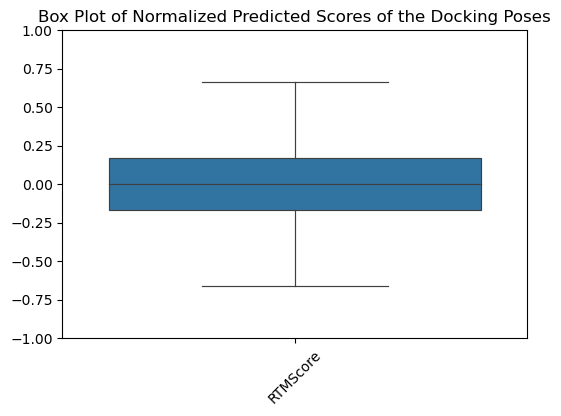

In [7]:
norm_scored_path = OUTPUT / 'best_correlation/all_rescoring_results_norm_robust.csv'
df_rescored = pd.read_csv(str(OUTPUT / 'best_correlation/all_rescoring_results.csv'))

df_rescored_norm = norm_scores(df_rescored)

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_rescored_norm ,linewidth=.85, showfliers=False)
plt.ylim(-1, 1)
plt.title('Box Plot of Normalized Predicted Scores of the Docking Poses')
plt.xticks(rotation=45) 
plt.show()

df_rescored_norm.to_csv(str(norm_scored_path), index=False)

In [10]:
rescored_library = pd.read_csv(str(norm_scored_path))
rescored_library['id'] = rescored_library.ID.str.split('_').str[0]

## Selected Ranking Method

In [11]:
from src.consensus_rank import method5_RbV

ranked_scores = method5_RbV(
    rescored_library,
    weight=0.5, 
    selected_columns=[
        'RTMScore',
        ],
    id_column='id'
    ).sort_values(by=['RbV'], ascending=False)

ranked_scores

,id,RbV
2837,CHEMBL3699591,5990.0
5176,CHEMBL5094480,5989.0
5236,CHEMBL5172251,5988.0
5127,CHEMBL5078413,5985.0
2609,CHEMBL3639984,5985.0
...,...,...
784,CHEMBL1828872,3.0
1831,CHEMBL307145,3.0
1761,CHEMBL290106,2.0
5897,CHEMBL77381,1.0


In [12]:
egfr_ligands_data = pd.read_csv(str(DATA / 'EGFR-activities-chembl33-sample.csv'))[
        [
            'activities.standard_type', 
            'molecule_dictionary.chembl_id', 
            'activities.standard_value', 
            'activities.standard_units', 
            'compound_structures.canonical_smiles',
        ]
    ]
egfr_ligands_data = egfr_ligands_data.rename(columns={
    'molecule_dictionary.chembl_id': 'id',
    'activities.standard_value': 'true_value',
    'activities.standard_units': 'standard_units',
    'compound_structures.canonical_smiles': 'canonical_smiles',
    'activities.standard_type': 'standard_type',
}).drop_duplicates(subset='id')
egfr_ligands_data['activity_class'] = egfr_ligands_data['true_value'].apply(lambda x: 1 if x >= 8 else 0)

true_value_df = ranked_scores.merge(egfr_ligands_data, on='id')
true_value_df.drop_duplicates()

,id,RbV,standard_type,true_value,standard_units,canonical_smiles,activity_class
0,CHEMBL3699591,5990.0,pIC50,7.187087,nM,C=CC(=O)Nc1cccc(Oc2nc(Nc3ccc(N4CCOCC4)cc3OC(F)...,0
1,CHEMBL5094480,5989.0,pIC50,9.045757,nM,COc1cc(N2CCC(N(C)C)CC2)c(-c2cn[nH]c2)cc1Nc1ncc...,1
2,CHEMBL5172251,5988.0,pIC50,8.200659,nM,CCc1cc(Nc2ncc(Cl)c(-c3cn(S(=O)(=O)CC)c4ccccc34...,1
3,CHEMBL5078413,5985.0,pIC50,8.619789,nM,CCP(=O)(CC)c1ccccc1Nc1nc(Nc2cc(-c3cnn(C)c3)c(N...,1
4,CHEMBL3639984,5985.0,pIC50,7.187087,nM,C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(N4CCN(C(=O)CO)CC4...,0
...,...,...,...,...,...,...,...
5986,CHEMBL1828872,3.0,pIC50,5.018181,nM,O=C(Cc1ccc(Cl)cc1)NS(=O)(=O)c1ccc(F)cc1,0
5987,CHEMBL307145,3.0,pIC50,5.910095,nM,Oc1cccc(O)c1O,0
5988,CHEMBL290106,2.0,pIC50,6.211832,nM,Oc1c(Cl)cc(Cl)cc1Sc1cc(Cl)cc(Cl)c1O,0
5989,CHEMBL77381,1.0,pIC50,2.866461,nM,N#C/C(=C/c1ccc[nH]1)C(=O)O,0


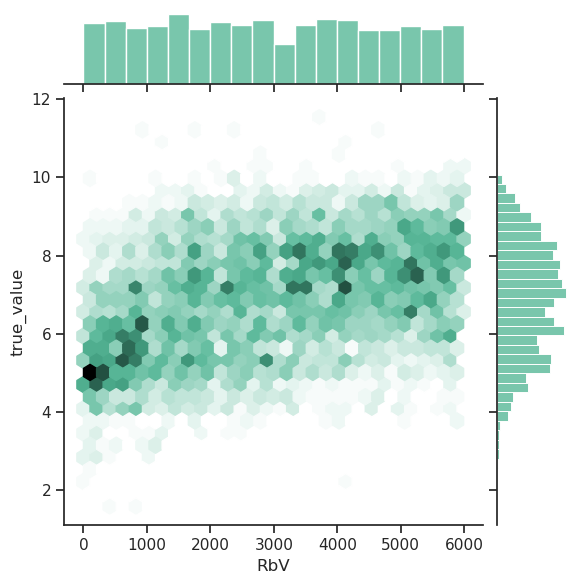

In [59]:
import numpy as np
import seaborn as sns

sns.set_theme(style="ticks")


sns.jointplot(x=true_value_df.RbV, y=true_value_df.true_value, kind="hex", color="#4CB391")

## Correlation Pipeline

In [26]:
spearman_corr, _ = spearmanr(true_value_df.RbV, true_value_df.true_value)
ef_1 = enrichment_factor_calc(true_value_df, percent=1, activity_class='activity_class')
ef_3 = enrichment_factor_calc(true_value_df, percent=3, activity_class='activity_class')
ef_5 = enrichment_factor_calc(true_value_df, percent=5, activity_class='activity_class')
ef_10 = enrichment_factor_calc(true_value_df, percent=10, activity_class='activity_class')

print(f"Spearman correlation of the train data is {spearman_corr}")
print(f"Enrichment factor for 1% is {ef_1*100}%")
print(f"Enrichment factor for 3% is {ef_3*100}%")
print(f"Enrichment factor for 5% is {ef_5*100}%")
print(f"Enrichment factor for 10% is {ef_10*100}%")

Spearman correlation of the train data is 0.4048759942194363
Enrichment factor for 1% is 189.01109660574411%
Enrichment factor for 3% is 191.18363794604%
Enrichment factor for 5% is 175.97584856396867%
Enrichment factor for 10% is 154.72556523710097%


## EF pipeline

In [19]:
spearman_corr, _ = spearmanr(true_value_df.method8_RbN, true_value_df.true_value)
ef_1 = enrichment_factor_calc(true_value_df, percent=1, activity_class='activity_class')
ef_3 = enrichment_factor_calc(true_value_df, percent=3, activity_class='activity_class')
ef_5 = enrichment_factor_calc(true_value_df, percent=5, activity_class='activity_class')
ef_10 = enrichment_factor_calc(true_value_df, percent=10, activity_class='activity_class')

print(f"Spearman correlation of the train data is {spearman_corr}")
print(f"Enrichment factor for 1% is {ef_1*100}%")
print(f"Enrichment factor for 3% is {ef_3*100}%")
print(f"Enrichment factor for 5% is {ef_5*100}%")
print(f"Enrichment factor for 10% is {ef_10*100}%")

Spearman correlation of the train data is 0.2733267484113711
Enrichment factor for 1% is 127.22138836772984%
Enrichment factor for 3% is 121.78777973346743%
Enrichment factor for 5% is 114.59865589367968%
Enrichment factor for 10% is 120.08476176093032%


## Scoring by filtering key interactions

In [32]:
interactions_scores_merged = ranked_scores.merge(agg_interx_df, on='id')
interactions_scores_merged

,id,RbV,842X,844X,844X,856X
0,CHEMBL5172251,5988.0,1.0,8.0,8.0,8.0
1,CHEMBL5078413,5985.0,1.0,6.0,6.0,10.0
2,CHEMBL5081299,5985.0,1.0,5.0,5.0,8.0
3,CHEMBL5087264,5982.0,1.0,6.0,6.0,7.0
4,CHEMBL5174418,5981.0,2.0,7.0,7.0,7.0
...,...,...,...,...,...,...
802,CHEMBL2325102,22.0,1.0,9.0,9.0,5.0
803,CHEMBL1173813,14.0,1.0,8.0,8.0,6.0
804,CHEMBL1172573,14.0,1.0,8.0,8.0,6.0
805,CHEMBL4640482,9.0,1.0,9.0,9.0,9.0


In [62]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

interactions_scores_merged = ranked_scores.merge(agg_interx_df, on='id')
features = interactions_scores_merged.columns[1:]
interactions_scores_merged[features] = interactions_scores_merged[features].apply(pd.to_numeric, errors='coerce')
display(interactions_scores_merged)
scaler = MinMaxScaler()
interactions_scores_merged[features] = scaler.fit_transform(interactions_scores_merged[features])
interactions_scores_merged['all_scores'] = interactions_scores_merged[features].sum(axis=1)
true_value_df_interactions = interactions_scores_merged.merge(egfr_ligands_data, on='id')
true_value_df_interactions.activity_class.value_counts()

,id,RbV,793X,844X,854X,856X
0,CHEMBL3699591,5990.0,10.0,9.0,3.0,9.0
1,CHEMBL5094480,5989.0,10.0,7.0,8.0,5.0
2,CHEMBL5172251,5988.0,10.0,8.0,4.0,8.0
3,CHEMBL5078413,5985.0,10.0,6.0,6.0,10.0
4,CHEMBL3639984,5985.0,10.0,8.0,1.0,10.0
...,...,...,...,...,...,...
5479,CHEMBL1173248,8.0,1.0,8.0,2.0,7.0
5480,CHEMBL1173250,6.0,1.0,8.0,2.0,9.0
5481,CHEMBL1822064,3.0,4.0,8.0,3.0,5.0
5482,CHEMBL1828872,3.0,1.0,8.0,4.0,6.0


activity_class
0    4069
1    1415
Name: count, dtype: int64

In [52]:
spearman_corr, _ = spearmanr(true_value_df_interactions.RbV, true_value_df_interactions.true_value)
ef_1 = enrichment_factor_calc(true_value_df_interactions, percent=1, activity_class='activity_class')
ef_3 = enrichment_factor_calc(true_value_df_interactions, percent=3, activity_class='activity_class')
ef_5 = enrichment_factor_calc(true_value_df_interactions, percent=5, activity_class='activity_class')
ef_10 = enrichment_factor_calc(true_value_df_interactions, percent=10, activity_class='activity_class')

print(f"Spearman correlation of the train data is {spearman_corr}")
print(f"Enrichment factor for 1% is {ef_1*100}%")
print(f"Enrichment factor for 3% is {ef_3*100}%")
print(f"Enrichment factor for 5% is {ef_5*100}%")
print(f"Enrichment factor for 10% is {ef_10*100}%")

Spearman correlation of the train data is 0.401095872845267
Enrichment factor for 1% is 190.25762929649855%
Enrichment factor for 3% is 197.30420815933178%
Enrichment factor for 5% is 173.97848907688734%
Enrichment factor for 10% is 157.71220757782876%


In [58]:
true_value_df_interactions.sort_values(by='RbV', ascending=False,inplace=True)
spearman_corr, _ = spearmanr(true_value_df_interactions.all_scores, true_value_df_interactions.true_value)
ef_1 = enrichment_factor_calc(true_value_df_interactions, percent=1, activity_class='activity_class')
ef_3 = enrichment_factor_calc(true_value_df_interactions, percent=3, activity_class='activity_class')
ef_5 = enrichment_factor_calc(true_value_df_interactions, percent=5, activity_class='activity_class')
ef_10 = enrichment_factor_calc(true_value_df_interactions, percent=10, activity_class='activity_class')

print(f"Spearman correlation of the train data is {spearman_corr}")
print(f"Enrichment factor for 1% is {ef_1*100}%")
print(f"Enrichment factor for 3% is {ef_3*100}%")
print(f"Enrichment factor for 5% is {ef_5*100}%")
print(f"Enrichment factor for 10% is {ef_10*100}%")

Spearman correlation of the train data is 0.3228106305848993
Enrichment factor for 1% is 197.30420815933178%
Enrichment factor for 3% is 194.9553485383874%
Enrichment factor for 5% is 175.39294833767505%
Enrichment factor for 10% is 157.71220757782876%
